<h3>Part 1 -- Autoencoder </h3>
<h5>Each cifar image is 32 X 32 X 3. This will be compressed to 8 X 8 X 8 using an autoencoder (3072 variables to 512 variables).</h5>

In [1]:
from keras.datasets import cifar100
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential, load_model

import copy
import matplotlib.pyplot as plt
import numpy as np
from autoencoder_utils import *
import math

(X_train, _), (X_test, _) = cifar100.load_data(label_mode='fine')

X_train = np.reshape(X_train, (len(X_train), 32, 32, 3)) / 255.
X_test = np.reshape(X_test, (len(X_test), 32, 32, 3)) / 255.

Using TensorFlow backend.


In [ ]:
autoencoder = Sequential()

input_shape = (32, 32, 3)
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=input_shape))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(MaxPooling2D((2, 2)))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(MaxPooling2D((2, 2)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))

autoencoder.add(Conv2D(8, (3, 3), activation='sigmoid', padding='same', name='encoded_layer'))
#at this point, 'encoded' is (8, 8, 8)

autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
autoencoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_crossentropy'])

In [ ]:
epochs = 30
batch_size = 64
training_batch_size = 1000
number_training_batch_per_epoch = math.ceil(X_train.shape[0] / training_batch_size)

#not the most ideal way of iterating through a dataset
for epoch in range(epochs):
    print('epoch: {}'.format(epoch))
    np.random.shuffle(X_train)
    np.random.shuffle(X_test)
    for batchnum in range(number_training_batch_per_epoch):
        X_train_batch = X_train[batchnum*training_batch_size : (batchnum+1)*training_batch_size]
        autoencoder.fit(X_train_batch, X_train_batch,
                        epochs=1,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(X_test[0:200], X_test[0:200]))


In [36]:
# from h5py import h5py

# autoencoder.save('autoencoder_cifar100_final.h5')
# autoencoder = load_model('autoencoder_cifar100_final.h5')

<h5>
The code below displays the original and autoencoded versions of 10 images.
<br>
In most cases, the original object can be discerned from the autoencoded version of the image.
</h5>

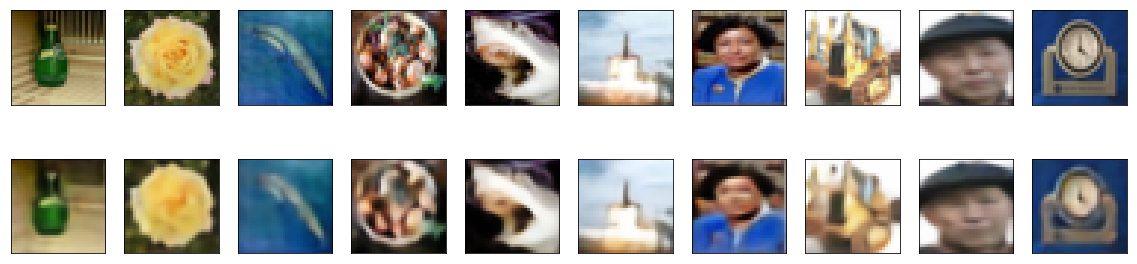

In [24]:
n = 10
img_to_show_idx = np.random.choice(range(X_test.shape[0]), n, replace=False)
X_test_to_show = X_test[img_to_show_idx]
aft_autoencode = autoencoder.predict(X_test_to_show)

fig = plt.figure(figsize=(n*2, 5))
plt.gray()
img_shape = (32, 32, 3)

for i in range(n):
    #display original
    display_single_subplot(X_test_to_show[i].reshape(img_shape), n_row=2, n_col=n, cell_num=i+1)
    #display aft autoencoding
    display_single_subplot(aft_autoencode[i].reshape(img_shape), n_row=2, n_col=n, cell_num=n+i+1)

plt.show()

<h3>
Part 2 -- selecting similar images
</h3>
<h5>
Given an image, select the most similar and dissimilar images, using binary cross entropy to determine similarity
</h5>

In [32]:
#find images similar to the image at this index
img_to_find_idx = 111

layer_name = 'encoded_layer'
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer(layer_name).output)

similarity_sorted = get_sorted_similarity_idx(encoder, img_to_find_idx, dataset=X_test, loss='binary_crossentropy')


<h5>
In most cases, images with a similar color / shape are deemed to be similar.
<br><br>
Images containing the same type of object aren't deemed to be similar, since the comparison function doesn't take object type into account.
</h5>

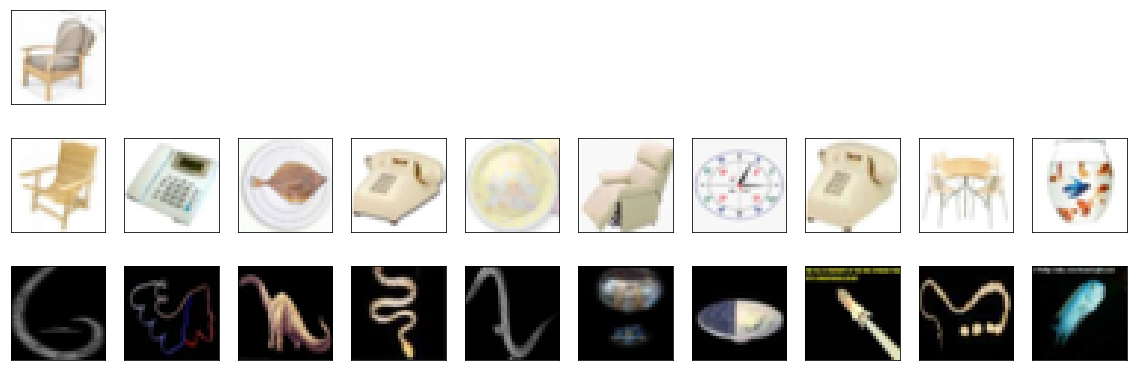

In [33]:
#show original image, n most similar images, n most dissimilar images
n = 10
image_dataset = X_test

plt.figure(figsize=(n*2, n/1.5))
img_shape = (32, 32, 3)

#display original
display_single_subplot(image_dataset[img_to_find_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=1)

# #display most similar
for i in range(n):
    similar_idx = similarity_sorted[i]
    display_single_subplot(image_dataset[similar_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=n+i+1)

# #display most dissimilar
for i in range(n):
    dissimilar_idx = similarity_sorted[-i-1]
    display_single_subplot(image_dataset[dissimilar_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=2*n+i+1)

plt.show()

<h5>Compare to 'baseline', binary cross entropy comparison of original image pixels.</h5>

In [37]:
import tensorflow as tf
from keras.losses import binary_crossentropy, cosine_proximity

img_to_find_idx = 111
dataset = copy.deepcopy(X_test)
dataset = dataset.reshape(dataset.shape[0], -1)
#initializing vars to pass into tensorflow
X_selected = [dataset[img_to_find_idx].tolist() for _ in range(dataset.shape[0])]
X_all = dataset.tolist()

import tensorflow as tf
from keras.losses import binary_crossentropy, cosine_proximity
X_selected_tf = tf.Variable(X_selected, tf.float32)
X_all_tf = tf.Variable(X_all, tf.float32)
loss_tf = binary_crossentropy(X_selected_tf, X_all_tf)
init_op = tf.global_variables_initializer()

similarity = []
with tf.Session() as sess:
    sess.run(init_op)
    similarity = sess.run(loss_tf)
similarity_sorted = np.argsort(np.array(similarity))[1:] #the same figure appears in X_all too, so remove it

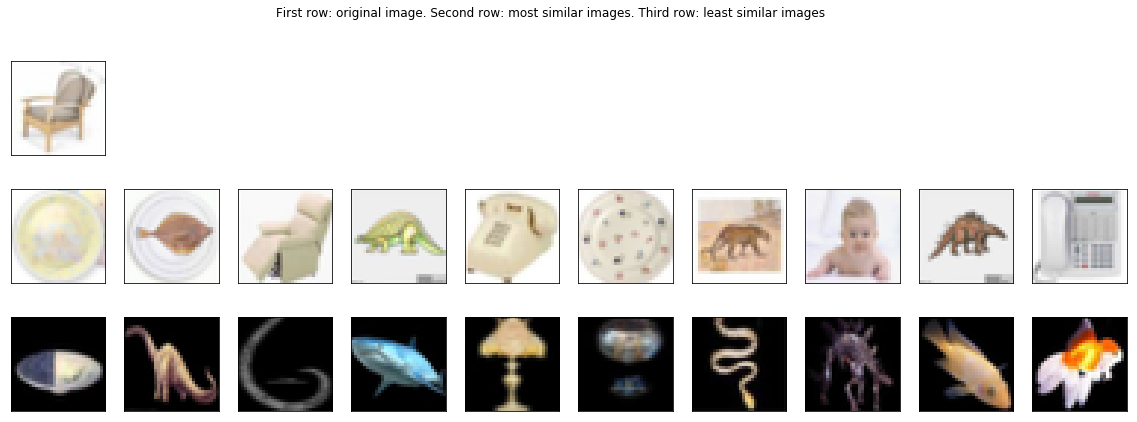

In [38]:
n=10
fig = plt.figure(figsize=(n*2, n/1.5))
plt.gray()
fig.suptitle('First row: original image. Second row: most similar images. Third row: least similar images')

img_shape = (32, 32, 3)

#display original
display_single_subplot(X_test[img_to_find_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=1)
#display most similar
for i in range(n):
    similar_idx = similarity_sorted[i]
    display_single_subplot(X_test[similar_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=n+i+1)
    
#display most dissimilar
for i in range(n):
    dissimilar_idx = similarity_sorted[-i-1]
    display_single_subplot(X_test[dissimilar_idx].reshape(img_shape), n_row=3, n_col=n, cell_num=2*n+i+1)

plt.show()